**Autores:**
1. Javier Quesada Pajares
2. Jorge del Castillo Gómez

# Modelo Baseline con Bert

En este notebook, se implementó un modelo baseline utilizando el fine-tuning de BERT-uncased. El conjunto de datos está compuesto por 1,000 frases humanas y 14,000 frases generadas por máquina, lo que resulta en un desbalanceo de clases. En este caso, no se incluyó un conjunto de validación ni un Dataloader.

Al evaluar el modelo en la fase de prueba, se observó que el rendimiento estaba afectado por el desbalanceo de las clases, como se observa en la curva ROC. Este comportamiento sugiere que el modelo tiene dificultades para aprender de manera efectiva debido a la falta de representatividad en las clases menos frecuentes.

Este modelo baseline servirá como punto de partida para implementar una arquitectura más compleja, como una arquitectura siamesa. El desarrollo de la arquitectura siamesa se localiza en el notebook "siamesaClassifier".

<h3><b> Evaluación </b></h3>

Las métricas devueltas por este modelo son pésimas (ROC_AUC Score = 0.59, 0.92). Una exactitud de 92% con una ROC_AUC de 0.5 indica que el modelo solo clasifica correctamente una clase debido al desbalanceo del dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers

## Librerias

In [ ]:
import pandas as pd
import json
import os

import numpy as np
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Preprocesado

In [ ]:
df_humans = pd.read_json('/content/drive/MyDrive/Universidad/Master/Primer semestre/Bloque_2/NLP/Proyecto/human.jsonl', lines=True)

In [ ]:
df_humans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1087 non-null   object
 1   text    1087 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


In [ ]:
df_humans['class'] = 0

In [ ]:
df_humans.head(5)

,id,text,class
0,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...,0
1,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...,0
2,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...,0
3,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak...",0
4,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...,0


In [ ]:
path = '/content/drive/MyDrive/Universidad/Master/Primer semestre/Bloque_2/NLP/Proyecto/machines/'

df_machines = None

for idx, file in enumerate(os.listdir(path)):
  print(f"Archivo {idx}")
  file_path = os.path.join(path, file)
  df_machine = pd.read_json(file_path, lines=True)
  df_machine['class'] = 1
  df_machines = pd.concat([df_machine, df_machines])

Archivo 0
Archivo 1
Archivo 2
Archivo 3
Archivo 4
Archivo 5
Archivo 6
Archivo 7
Archivo 8
Archivo 9
Archivo 10
Archivo 11
Archivo 12


In [ ]:
df_machines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14131 entries, 0 to 1086
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      14131 non-null  object
 1   text    14131 non-null  object
 2   class   14131 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 441.6+ KB


In [ ]:
df_machines.tail(5)

,id,text,class
1082,bigscience-bloomz-7b1/news-2021-01-01-2021-12-...,A 21-year-old University of Wyoming student wa...,1
1083,bigscience-bloomz-7b1/news-2021-01-01-2021-12-...,It was a cross-country trip from New York Stat...,1
1084,bigscience-bloomz-7b1/news-2021-01-01-2021-12-...,A TikTok user says she had a ride from an acqu...,1
1085,bigscience-bloomz-7b1/news-2021-01-01-2021-12-...,"Gabrielle ""Gabby"" Petito's death sparked a nat...",1
1086,bigscience-bloomz-7b1/news-2021-01-01-2021-12-...,The remains of a 25-year-old woman found in th...,1


## Creacion de training y test set

In [ ]:
df = pd.concat([df_humans, df_machines])
print(f"Número de clases: {df['class'].value_counts()}")

Número de clases: class
1    14131
0     1087
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split


X = df
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Esto asegura que la proporción de clases se mantenga
)

print("Después de la división:")
print(f"Training samples: {X_train['class'].value_counts()}")
print(f"Testing samples: {X_test['class'].value_counts()}")


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Después de la división:
Training samples: class
1    11304
0      870
Name: count, dtype: int64
Testing samples: class
1    2827
0     217
Name: count, dtype: int64


In [ ]:
X_train.head(3)

,id,text,class
0,mistralai-mistral-7b-instruct-v0.2/news-2021-0...,Beyond Blue Lines: The Interconnected Crises o...,1
1,articles-cleaned-truncated/news-2021-01-01-202...,Kyle Rittenhouse verdict: Protests continue in...,0
2,gemini-pro/news-2021-01-01-2021-12-31-cnnchris...,CNN's Anderson Cooper Addresses Chris Cuomo Fi...,1


## Definición de CustomDataset

In [ ]:
MAX_LEN = 128 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 10 # @param {type:"integer"}
VALID_BATCH_SIZE = 5 # @param {type:"integer"}
EPOCHS = 2 # @param {type:"integer"}
LEARNING_RATE = 1e-4 # @param {type:"number"}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.target = self.data['class']
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):

        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        # Tokeniza el comentario usando encode_plus
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_len,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            add_special_tokens=True,
            padding='max_length'
        )


        ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
        mask = torch.tensor(encoding['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(encoding['token_type_ids'], dtype=torch.long)
        target_value = self.target.iloc[index] if isinstance(self.target, pd.Series) else self.target[index]

        return {
            'ids': ids,
            'mask': mask,
            'token_type_ids': token_type_ids,
            'target': torch.tensor(target_value, dtype=torch.float)
        }

In [ ]:
train_dataset = CustomDataset(X_train, tokenizer, MAX_LEN)
test_dataset = CustomDataset(X_test, tokenizer, MAX_LEN)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(X_train.shape))
print("TEST Dataset: {}".format(X_test.shape))


train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)

FULL Dataset: (15218, 3)
TRAIN Dataset: (12174, 3)
TEST Dataset: (3044, 3)


In [ ]:
MAX_LEN = 128  # Longitud máxima para el padding
ca = CustomDataset(X_train, tokenizer, MAX_LEN)

# Obtener los IDs, máscara y token_type_ids del primer elemento
sample = ca.__getitem__(0)
ids = sample['ids']
mask = sample['mask']
token_type_ids = sample['token_type_ids']
targets = sample['target']

# Imprimir los resultados
print("Input IDs:", ids)
print("Attention Mask:", mask)
print("Token Type IDs:", token_type_ids)

Input IDs: tensor([  101,  3458,  2630,  3210,  1024,  1996,  6970, 24230, 25332,  1997,
         2610,  4808,  1998,  3282,  3226,  1999,  2637,  2004,  1996,  7256,
        15775,  2226,  6371,  3979,  4895, 10371,  2015,  1010,  1996,  3842,
         1005,  1055,  7268,  3657,  3464,  4208,  2006,  2610, 24083,  1998,
        22575, 14398,  1012,  2174,  1010,  1996, 13800, 13693,  1997,  3522,
         2824,  1517,  2007,  2058, 16471,  3742,  5008,  2015,  1999,  1996,
         2149,  2004,  1997,  2258,  5767,  1010,  1998,  2062,  2084,  3438,
         2111,  2730,  2011,  2610,  2076,  2023,  2558,  1010,  2116,  1997,
         2068,  2304,  2030,  1997,  3763,  2137,  6934,  1517,  7670,  1037,
         2062,  7721,  7749,  1997,  1996,  6970, 16570,  4383, 25332,  1997,
         2610,  4808,  1998,  3282,  3226,  1999,  2637,  1012,  2070,  2610,
         1998,  2037,  4505,  7475,  2114,  3282,  5290,  1010,  8498,  2008,
         1996,  2117,  7450,  2157,  2000,  4562,  26

## Modelo BERT preentrenado con Fine Tuning

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        # Declaración de las capas
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(self.dropout_rate)  # Dropout con la tasa de 0.3
        self.l3 = torch.nn.Linear(self.hidden_embd, self.output_layer)  # Capa lineal final

    def forward(self, ids, mask, token_type_ids):
        # Forward pass a través de BERT
        outputs = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = outputs[1]  # Extraer el "pooled output" que representa la secuencia completa

        # dropout y luego la capa lineal
        output_2 = self.l2(output_1)
        output = self.l3(output_2)

        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [ ]:
# Se define la funcion pérdida

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()

    for i, data in enumerate(training_loader, 0):

      ids = data['ids'].to(device, dtype=torch.long)
      mask = data['mask'].to(device, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
      targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)  # tamaño [batch_size, 1]


      # 2. Reiniciar los gradientes acumulados
      optimizer.zero_grad()

      # 3. Realizar la predicción
      outputs = model(ids, mask, token_type_ids)

      # 4. Calcular la pérdida
      loss = loss_fn(outputs, targets)

      # 5. Propagar el error hacia atrás
      loss.backward()

      # 6. Actualizar los parámetros del modelo
      optimizer.step()

      # Imprimir la pérdida cada 100 iteraciones
      if i % 100 == 0:
          print(f'Batch: {i}, Loss:  {loss.item()}')

In [ ]:
for epoch in range(EPOCHS):
  print(f"epoch[{epoch}]")
  train(epoch)

epoch[0]
Batch: 0, Loss:  0.5845123529434204
Batch: 100, Loss:  0.6157670021057129
Batch: 200, Loss:  0.5512221455574036
Batch: 300, Loss:  0.6402165293693542
Batch: 400, Loss:  0.6267732977867126
Batch: 500, Loss:  0.06215403601527214
Batch: 600, Loss:  0.09495668113231659
Batch: 700, Loss:  0.5809304118156433
Batch: 800, Loss:  0.9220059514045715
Batch: 900, Loss:  0.07339320331811905
Batch: 1000, Loss:  0.9284906387329102
Batch: 1100, Loss:  0.04230817034840584
Batch: 1200, Loss:  0.10369520634412766
epoch[1]
Batch: 0, Loss:  0.3425312638282776
Batch: 100, Loss:  0.3690107762813568
Batch: 200, Loss:  0.06520626693964005
Batch: 300, Loss:  0.08064987510442734
Batch: 400, Loss:  0.31555619835853577
Batch: 500, Loss:  0.0704139694571495
Batch: 600, Loss:  0.12237324565649033
Batch: 700, Loss:  0.053301066160202026
Batch: 800, Loss:  0.5237986445426941
Batch: 900, Loss:  0.3505133092403412
Batch: 1000, Loss:  0.06623934954404831
Batch: 1100, Loss:  0.29122820496559143
Batch: 1200, Loss:

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As defined above to get a measure of our models performance we are using the following metrics.
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.
def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total

def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation(epoch):
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids, mask, token_type_ids)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(epoch)
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs2)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"Accuracy Score = {accuracy}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.9287122207621551
ROC_AUC Score = 0.5905830707512646
F1 Score = 0.9630386646227218
F0.5 Score = 0.9421449043524628
Accuracy Score = 0.9287122207621551
Brier Score = 0.9287122207621551


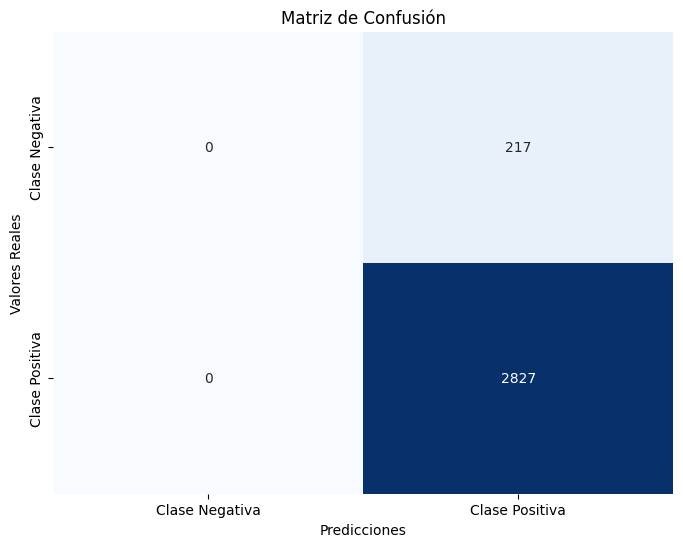

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculamos la matriz de confusión
cm = confusion_matrix(targets, outputs2)

# Creamos un heatmap (mapa de calor) de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Guardado del modelo
torch.save(model.state_dict(), 'baseline_model.pth')